In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

diabetes = pd.read_csv('data/diabetes_data.csv')
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               778 non-null    int64  
 1   Glucose                   778 non-null    int64  
 2   BloodPressure             778 non-null    int64  
 3   SkinThickness             778 non-null    int64  
 4   Insulin                   778 non-null    int64  
 5   BMI                       778 non-null    float64
 6   DiabetesPedigreeFunction  778 non-null    float64
 7   Age                       778 non-null    int64  
 8   Outcome                   778 non-null    int64  
 9   Gender                    778 non-null    object 
dtypes: float64(2), int64(7), object(1)
memory usage: 60.9+ KB


Задание 8.1

Начнём с поиска дубликатов в данных. Найдите все повторяющиеся строки в данных и удалите их. Для поиска используйте все признаки в данных. Сколько записей осталось в данных?

In [2]:
dupl_col = list(diabetes.columns)
diabetes = diabetes.drop_duplicates(subset=dupl_col)
diabetes.shape[0]

768

Задание 8.2
1 point possible (graded)
Далее найдите все неинформативные признаки в данных и избавьтесь от них. В качестве порога информативности возьмите 0.95: удалите все признаки, для которых 95 % значений повторяются или 95 % записей уникальны. В ответ запишите имена признаков, которые вы нашли (без кавычек).

In [3]:
      
def detect_low_information_cols(df):
    #список неинформативных признаков
    low_information_cols = [] 
    
    #цикл по всем столбцам
    for col in df.columns:
        #наибольшая относительная частота в признаке
        top_freq = df[col].value_counts(normalize=True).max()
        #доля уникальных значений от размера признака
        nunique_ratio = df[col].nunique() / df[col].count()
        # сравниваем наибольшую частоту с порогом
        if top_freq > 0.95:
            low_information_cols.append(col)
            print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
        if nunique_ratio > 0.95:
            low_information_cols.append(col)
            print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
    return low_information_cols

lst_low = detect_low_information_cols(diabetes)
diabetes = diabetes.drop(columns='Gender')
diabetes.columns

Gender: 100.0% одинаковых значений


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Задание 8.3

Попробуйте найти пропуски в данных с помощью метода isnull()
Замените все записи, равные 0, в столбцах Glucose, BloodPressure, SkinThickness, Insulin и BMI на символ пропуска. Его вы можете взять из библиотеки numpy: np.nan.

Какая доля пропусков содержится в столбце Insulin? Ответ округлите до сотых.

In [4]:
col_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI']
for col_name in col_list:
    diabetes[col_name] = diabetes[col_name].replace(0, np.nan)
    
print(diabetes.isnull()['Insulin'].value_counts(normalize=True).round(2).loc[True])


0.49


Задание 8.4

Удалите из данных признаки, где число пропусков составляет более 30 %. Сколько признаков осталось в ваших данных (с учетом удаленных неинформативных признаков в задании 8.2)?

In [5]:
#создаем минимальный порог: вычисляем 70% от числа строк
thrash = diabetes.shape[0]*0.7
#удаляем пропуски
diabetes = diabetes.dropna(thresh=thrash, axis=1)
#оставшиися калонки
diabetes.shape[1]

8

Задание 8.5

Удалите из данных только те строки, в которых содержится более двух пропусков одновременно. Чему равно результирующее число записей в таблице?

In [6]:
diabetes = diabetes.dropna(thresh=diabetes.shape[1]-2, axis=0)
diabetes.shape[0]

761

Задание 8.6

В оставшихся записях замените пропуски на медиану. Чему равно среднее значение в столбце SkinThickness? Ответ округлите до десятых.

In [7]:
values = {}
for col in diabetes.columns:
    values.update({col:diabetes[col].median()})
values

diabetes = diabetes.fillna(values)

diabetes['SkinThickness'].mean()

29.109067017082786

Задание 8.7

Сколько выбросов найдёт классический метод межквартильного размаха в признаке SkinThickness?

In [8]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
        
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

SkinThickness_out, SkinThickness_cleaned = outliers_iqr_mod(diabetes, 'SkinThickness')
SkinThickness_out.shape[0]

87

Задание 8.8

Сколько выбросов найдёт классический метод z-отклонения в признаке SkinThickness?

In [9]:
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

SkinThickness_out, SkinThickness_cleaned = outliers_z_score_mod(diabetes, 'SkinThickness')

SkinThickness_out.shape[0]

4

Задание 8.9

На приведённой гистограмме показано распределение признака DiabetesPedigreeFunction. Такой вид распределения очень похож на логнормальный, и он заставляет задуматься о логарифмировании признака. Найдите сначала число выбросов в признаке DiabetesPedigreeFunction с помощью классического метода межквартильного размаха.

Затем найдите число выбросов в этом же признаке в логарифмическом масштабе (при логарифмировании единицу прибавлять не нужно!). Какова разница между двумя этими числами (вычтите из первого второе)?

<AxesSubplot: ylabel='Frequency'>

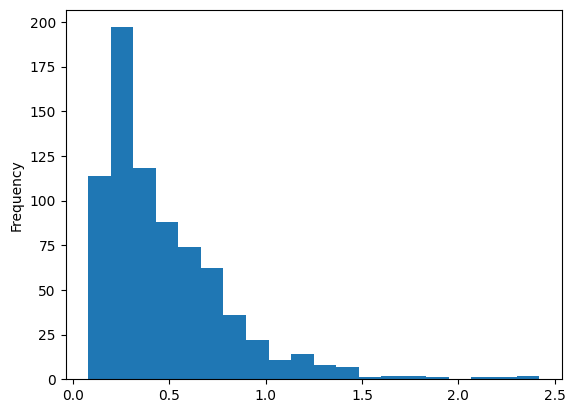

In [10]:
diabetes['DiabetesPedigreeFunction'].plot(
    kind='hist',
    bins=20
)

In [11]:
DiabetesPedigreeFunction_out1 ,tamp = outliers_iqr_mod(diabetes, 'DiabetesPedigreeFunction')

DiabetesPedigreeFunction_out2, tamp =outliers_iqr_mod(diabetes, 'DiabetesPedigreeFunction', log_scale=True)


DiabetesPedigreeFunction_out1.shape[0] - DiabetesPedigreeFunction_out2.shape[0]

29